![Redis](https://redis.io/wp-content/uploads/2024/04/Logotype.svg?auto=webp&quality=85,75&width=120)

# 🤖 Section 4: Building a Redis University Course Advisor Agent

**⏱️ Estimated Time:** 60-75 minutes

## 🎯 Learning Objectives

By the end of this notebook, you will:

1. **Build** a complete LangGraph agent with tools and memory
2. **Implement** exactly 3 tools: memory storage, memory search, and course search
3. **Integrate** Redis Agent Memory Server for dual-memory architecture
4. **Visualize** the agent's decision-making graph
5. **Demonstrate** the progression from RAG (Section 3) to full agent

---

## 🔗 Bridge from Previous Sections

### **Your Learning Journey:**

**Section 1:** Context Types
- System, User, Conversation, Retrieved context
- How context shapes LLM responses

**Section 2:** RAG Foundations
- Semantic search with vector embeddings
- Retrieving and presenting information
- Single-step retrieval → generation

**Section 3:** Memory Architecture
- Working memory (conversation continuity)
- Long-term memory (persistent knowledge)
- Memory-enhanced RAG systems

**Section 4 (Notebook 1):** Tool-Calling Basics
- What tools are and how LLMs use them
- LangGraph fundamentals (nodes, edges, state)
- Simple tool-calling examples
- Agents vs RAG comparison

### **What We're Building Now:**

**A Full Agent** that combines everything:
- ✅ **Tools** for actions (search courses, manage memory)
- ✅ **Memory** for personalization (working + long-term)
- ✅ **RAG** for course information (semantic search)
- ✅ **LangGraph** for orchestration (state management)

**💡 Key Insight:** This agent is RAG + Memory + Tools + Decision-Making

---

## 📊 Agent Architecture

### **The Complete Flow:**

```
User Query
    ↓
[Load Working Memory] ← Conversation history
    ↓
[Agent Node] ← Decides what to do
    ↓
    ├─→ [search_courses] ← Find relevant courses
    ├─→ [search_memories] ← Recall user preferences
    ├─→ [store_memory] ← Save important facts
    ↓
[Agent Node] ← Processes tool results
    ↓
[Generate Response] ← Final answer
    ↓
[Save Working Memory] ← Update conversation
```

### **Our 3 Tools:**

1. **`search_courses`** - Semantic search over course catalog
   - When: Student asks about courses, topics, or recommendations
   - Example: "What machine learning courses are available?"

2. **`search_memories`** - Search long-term memory for user facts
   - When: Need to recall preferences, goals, or past interactions
   - Example: "What courses did I say I was interested in?"

3. **`store_memory`** - Save important information to long-term memory
   - When: User shares preferences, goals, or important facts
   - Example: "I'm interested in AI and want to work at a startup"

### **Memory Architecture:**

| Memory Type | Purpose | Managed By | Lifespan |
|------------|---------|------------|----------|
| **Working Memory** | Conversation history | Agent Memory Server | Session |
| **Long-term Memory** | User preferences, facts | Agent Memory Server | Persistent |
| **Graph State** | Current execution state | LangGraph | Single turn |

---

## 📦 Setup and Environment

### ⚠️ **CRITICAL: Prerequisites Required**

**This notebook requires ALL services to be running. If any service is down, the agent will not work.**

**Required Services:**
1. **Redis** - Vector storage and caching (port 6379)
2. **Agent Memory Server** - Memory management (port 8088)
3. **OpenAI API** - LLM functionality

**🚀 Quick Setup (Run this first!):**
```bash
# Navigate to notebooks_v2 directory
cd ../../

# Check if services are running
./check_setup.sh

# If services are down, run setup
./setup_memory_server.sh
```

**📖 Need help?** See `../SETUP_GUIDE.md` for detailed setup instructions.

**🔍 Manual Check:**
- Redis: `redis-cli ping` should return `PONG`
- Memory Server: `curl http://localhost:8088/v1/health` should return `{"status":"ok"}`
- Environment: Create `.env` file in `reference-agent/` with your `OPENAI_API_KEY`


---


### Automated Setup Check

Let's run the setup script to ensure all services are running properly.


In [1]:
# Run the setup script to ensure Redis and Agent Memory Server are running
import subprocess
import sys
from pathlib import Path

# Path to setup script
setup_script = Path("../../reference-agent/setup_agent_memory_server.py")

if setup_script.exists():
    print("Running automated setup check...\n")
    result = subprocess.run(
        [sys.executable, str(setup_script)],
        capture_output=True,
        text=True
    )
    print(result.stdout)
    if result.returncode != 0:
        print("⚠️  Setup check failed. Please review the output above.")
        print(result.stderr)
    else:
        print("\n✅ All services are ready!")
else:
    print("⚠️  Setup script not found. Please ensure services are running manually.")


Running automated setup check...




🔧 Agent Memory Server Setup
📊 Checking Redis...
✅ Redis is running
📊 Checking Agent Memory Server...
🔍 Agent Memory Server container exists. Checking health...
✅ Agent Memory Server is running and healthy
✅ No Redis connection issues detected

✅ Setup Complete!
📊 Services Status:
   • Redis: Running on port 6379
   • Agent Memory Server: Running on port 8088

🎯 You can now run the notebooks!


✅ All services are ready!


---


### Install Dependencies

If you haven't already installed the reference-agent package, uncomment and run the following:


In [2]:
# Uncomment to install reference-agent package
# %pip install -q -e ../../reference-agent

# Uncomment to install agent-memory-client
# %pip install -q agent-memory-client


### Import Libraries


In [3]:
# Core libraries
import os
import sys
import json
from typing import List, Dict, Any, Optional, Annotated
from datetime import datetime
from dotenv import load_dotenv

# LangChain and LangGraph
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field

# Redis and Agent Memory
from agent_memory_client import MemoryAPIClient, MemoryClientConfig
from agent_memory_client.models import WorkingMemory, MemoryMessage

# Add reference-agent to path for course utilities
sys.path.insert(0, os.path.abspath("../../reference-agent"))
from redis_context_course.course_manager import CourseManager
from redis_context_course.models import StudentProfile, DifficultyLevel, CourseFormat

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


### Load Environment Variables


In [4]:
# Load environment variables
load_dotenv("../../reference-agent/.env")

# Get configuration
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
REDIS_URL = os.getenv("REDIS_URL", "redis://localhost:6379")
AGENT_MEMORY_URL = os.getenv("AGENT_MEMORY_URL", "http://localhost:8088")

# Verify OpenAI API key
if not OPENAI_API_KEY:
    raise ValueError("""
    ⚠️  OPENAI_API_KEY not found!
    
    Please create a .env file in the reference-agent directory:
    1. cd ../../reference-agent
    2. cp .env.example .env
    3. Edit .env and add your OpenAI API key
    """)

print("✅ Environment configured successfully!")
print(f"   OpenAI API Key: {'*' * 20}{OPENAI_API_KEY[-4:]}")
print(f"   Redis URL: {REDIS_URL}")
print(f"   Agent Memory URL: {AGENT_MEMORY_URL}")

✅ Environment configured successfully!
   OpenAI API Key: ********************wTMA
   Redis URL: redis://localhost:6379
   Agent Memory URL: http://localhost:8088


### Check Required Services

Let's verify that Redis and the Agent Memory Server are running.


In [5]:
import redis
import requests

# Check Redis
try:
    redis_client = redis.from_url(REDIS_URL)
    redis_client.ping()
    print("✅ Redis is running")
    REDIS_AVAILABLE = True
except Exception as e:
    print(f"❌ Redis is not available: {e}")
    print("   Please start Redis using Docker:")
    print("   docker run -d -p 6379:6379 redis/redis-stack:latest")
    REDIS_AVAILABLE = False

# Check Agent Memory Server
try:
    response = requests.get(f"{AGENT_MEMORY_URL}/v1/health", timeout=2)
    if response.status_code == 200:
        print("✅ Agent Memory Server is running")
        MEMORY_SERVER_AVAILABLE = True
    else:
        print(f"⚠️  Agent Memory Server returned status {response.status_code}")
        MEMORY_SERVER_AVAILABLE = False
except Exception as e:
    print(f"❌ Agent Memory Server is not available: {e}")
    print("   Please start the Agent Memory Server:")
    print("   cd ../../reference-agent && python setup_agent_memory_server.py")
    MEMORY_SERVER_AVAILABLE = False

if not (REDIS_AVAILABLE and MEMORY_SERVER_AVAILABLE):
    print("\n⚠️  Some services are not available. Please start them before continuing.")
else:
    print("\n✅ All services are ready!")

✅ Redis is running
✅ Agent Memory Server is running

✅ All services are ready!


---

## 🔧 Initialize Components

Now let's initialize the components we'll use to build our agent.


### Initialize Course Manager

The `CourseManager` handles course storage and semantic search, just like in Section 2.


In [6]:
# Initialize Course Manager
course_manager = CourseManager()

print("✅ Course Manager initialized")
print("   Ready to search and retrieve courses")

19:57:53 redisvl.index.index INFO   Index already exists, not overwriting.


✅ Course Manager initialized
   Ready to search and retrieve courses


### Initialize LLM

We'll use GPT-4o with temperature=0.0 for consistent, deterministic responses.


In [7]:
# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

print("✅ LLM initialized")
print("   Model: gpt-4o")
print("   Temperature: 0.0 (deterministic)")

✅ LLM initialized
   Model: gpt-4o
   Temperature: 0.0 (deterministic)


### Initialize Memory Client

The memory client handles both working memory (conversation history) and long-term memory (persistent facts).


In [8]:
# Initialize Memory Client
config = MemoryClientConfig(
    base_url=AGENT_MEMORY_URL,
    default_namespace="redis_university"
)
memory_client = MemoryAPIClient(config=config)

print("✅ Memory Client initialized")
print(f"   Base URL: {config.base_url}")
print(f"   Namespace: {config.default_namespace}")
print("   Ready for working memory and long-term memory operations")

✅ Memory Client initialized
   Base URL: http://localhost:8088
   Namespace: redis_university
   Ready for working memory and long-term memory operations


### Create Sample Student Profile

We'll create a sample student to use throughout our demos.


In [9]:
# Create sample student profile
STUDENT_ID = "student_sarah_001"
SESSION_ID = f"session_{STUDENT_ID}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

sarah = StudentProfile(
    name="Sarah Chen",
    email="sarah.chen@university.edu",
    major="Computer Science",
    year=2,
    interests=["machine learning", "data science", "algorithms"],
    completed_courses=["Introduction to Programming", "Data Structures"],
    current_courses=["Linear Algebra"],
    preferred_format=CourseFormat.ONLINE,
    preferred_difficulty=DifficultyLevel.INTERMEDIATE
)

print("✅ Student profile created")
print(f"   Name: {sarah.name}")
print(f"   Student ID: {STUDENT_ID}")
print(f"   Session ID: {SESSION_ID}")
print(f"   Major: {sarah.major}")
print(f"   Interests: {', '.join(sarah.interests)}")

✅ Student profile created
   Name: Sarah Chen
   Student ID: student_sarah_001
   Session ID: session_student_sarah_001_20251031_195753
   Major: Computer Science
   Interests: machine learning, data science, algorithms


---

## 🛠️ Part 1: Define the Agent's Tools

Let's build our 3 tools step by step. Each tool will have:
- Clear input schema (what parameters it accepts)
- Descriptive docstring (tells the LLM when to use it)
- Implementation (the actual logic)

**Remember:** The LLM only sees the tool name, description, and parameters—not the implementation!


### Tool 1: `search_courses`

This tool searches the course catalog using semantic search.


In [10]:
# Define input schema
class SearchCoursesInput(BaseModel):
    """Input schema for searching courses."""
    query: str = Field(
        description="Natural language search query. Can be topics (e.g., 'machine learning'), "
                    "characteristics (e.g., 'online courses'), or general questions "
                    "(e.g., 'beginner programming courses')"
    )
    limit: int = Field(
        default=5,
        description="Maximum number of results to return. Default is 5. "
                    "Use 3 for quick answers, 10 for comprehensive results."
    )

# Define the tool
@tool("search_courses", args_schema=SearchCoursesInput)
async def search_courses(query: str, limit: int = 5) -> str:
    """
    Search for courses using semantic search based on topics, descriptions, or characteristics.
    
    Use this tool when students ask about:
    - Topics or subjects: "machine learning courses", "database courses"
    - Course characteristics: "online courses", "beginner courses", "3-credit courses"
    - General exploration: "what courses are available in AI?"
    
    The search uses semantic matching, so natural language queries work well.
    
    Returns: Formatted list of matching courses with details.
    """
    results = await course_manager.search_courses(query, limit=limit)
    
    if not results:
        return "No courses found matching your query."
    
    output = []
    for course in results:
        output.append(
            f"{course.course_code}: {course.title}\n"
            f"  Credits: {course.credits} | {course.format.value} | {course.difficulty_level.value}\n"
            f"  {course.description[:150]}..."
        )
    
    return "\n\n".join(output)

print("✅ Tool 1 defined: search_courses")
print("   Purpose: Search course catalog with semantic search")
print("   Parameters: query (str), limit (int)")

✅ Tool 1 defined: search_courses
   Purpose: Search course catalog with semantic search
   Parameters: query (str), limit (int)


### Tool 2: `search_memories`

This tool searches long-term memory for user preferences and facts.


In [11]:
# Define input schema
class SearchMemoriesInput(BaseModel):
    """Input schema for searching memories."""
    query: str = Field(
        description="Natural language query to search for in user's long-term memory. "
                    "Examples: 'career goals', 'course preferences', 'learning style'"
    )
    limit: int = Field(
        default=5,
        description="Maximum number of memories to return. Default is 5."
    )

# Define the tool
@tool("search_memories", args_schema=SearchMemoriesInput)
async def search_memories(query: str, limit: int = 5) -> str:
    """
    Search the user's long-term memory for relevant facts, preferences, and past interactions.
    
    Use this tool when you need to:
    - Recall user preferences: "What format does the user prefer?"
    - Remember past goals: "What career path is the user interested in?"
    - Find previous interactions: "What courses did we discuss before?"
    - Personalize recommendations: "What are the user's interests?"
    
    The search uses semantic matching to find relevant memories.
    
    Returns: List of relevant memories with content and metadata.
    """
    try:
        from agent_memory_client.filters import UserId
        
        # Search long-term memory
        results = await memory_client.search_long_term_memory(
            text=query,
            user_id=UserId(eq=STUDENT_ID),
            limit=limit
        )
        
        if not results.memories or len(results.memories) == 0:
            return "No relevant memories found."
        
        output = []
        for i, memory in enumerate(results.memories, 1):
            output.append(f"{i}. {memory.text}")
            if memory.topics:
                output.append(f"   Topics: {', '.join(memory.topics)}")
        
        return "\n".join(output)
    except Exception as e:
        return f"Error searching memories: {str(e)}"

print("✅ Tool 2 defined: search_memories")
print("   Purpose: Search long-term memory for user facts")
print("   Parameters: query (str), limit (int)")

✅ Tool 2 defined: search_memories
   Purpose: Search long-term memory for user facts
   Parameters: query (str), limit (int)


### Tool 3: `store_memory`

This tool saves important information to long-term memory.


In [12]:
# Define input schema
class StoreMemoryInput(BaseModel):
    """Input schema for storing memories."""
    text: str = Field(
        description="The information to store. Should be a clear, factual statement. "
                    "Examples: 'User prefers online courses', 'User's career goal is AI research'"
    )
    memory_type: str = Field(
        default="semantic",
        description="Type of memory: 'semantic' (facts/preferences), 'episodic' (events/interactions). "
                    "Default is 'semantic'."
    )
    topics: List[str] = Field(
        default=[],
        description="Optional tags to categorize the memory, such as ['preferences', 'courses']"
    )

# Define the tool
@tool("store_memory", args_schema=StoreMemoryInput)
async def store_memory(text: str, memory_type: str = "semantic", topics: List[str] = []) -> str:
    """
    Store important information to the user's long-term memory.
    
    Use this tool when the user shares:
    - Preferences: "I prefer online courses", "I like hands-on projects"
    - Goals: "I want to work in AI", "I'm preparing for grad school"
    - Important facts: "I have a part-time job", "I'm interested in startups"
    - Constraints: "I can only take 2 courses per semester"
    
    Do NOT store:
    - Temporary information (use conversation context instead)
    - Course details (already in course catalog)
    - General questions
    
    Returns: Confirmation message.
    """
    try:
        from agent_memory_client.models import ClientMemoryRecord
        
        # Create memory record
        memory = ClientMemoryRecord(
            text=text,
            user_id=STUDENT_ID,
            memory_type=memory_type,
            topics=topics or []
        )
        
        # Store in long-term memory
        await memory_client.create_long_term_memory([memory])
        return f"✅ Stored to long-term memory: {text}"
    except Exception as e:
        return f"Error storing memory: {str(e)}"

print("✅ Tool 3 defined: store_memory")
print("   Purpose: Save important facts to long-term memory")
print("   Parameters: text (str), memory_type (str), topics (List[str])")

✅ Tool 3 defined: store_memory
   Purpose: Save important facts to long-term memory
   Parameters: text (str), memory_type (str), topics (List[str])


### Tools Summary

Let's review our 3 tools:


In [13]:
# Collect all tools
tools = [search_courses, search_memories, store_memory]

print("=" * 80)
print("🛠️  AGENT TOOLS SUMMARY")
print("=" * 80)
for i, tool in enumerate(tools, 1):
    print(f"\n{i}. {tool.name}")
    print(f"   Description: {tool.description.split('.')[0]}")
    print(f"   Parameters: {', '.join(tool.args_schema.model_fields.keys())}")
print("\n" + "=" * 80)

🛠️  AGENT TOOLS SUMMARY

1. search_courses
   Description: Search for courses using semantic search based on topics, descriptions, or characteristics
   Parameters: query, limit

2. search_memories
   Description: Search the user's long-term memory for relevant facts, preferences, and past interactions
   Parameters: query, limit

3. store_memory
   Description: Store important information to the user's long-term memory
   Parameters: text, memory_type, topics



---

## 🎨 Part 2: Define the Agent State

In LangGraph, **state** is the shared data structure that flows through the graph. Each node can read from and write to the state.

### What Goes in State?

- **messages**: Conversation history (automatically managed by LangGraph)
- **student_id**: Who we're helping
- **session_id**: Current conversation session
- **context**: Additional context (memories, preferences, etc.)

**Note:** We use `Annotated[List[BaseMessage], add_messages]` for messages. The `add_messages` reducer automatically handles message deduplication and ordering.


In [14]:
# Define the agent state
class AgentState(BaseModel):
    """State for the course advisor agent."""
    messages: Annotated[List[BaseMessage], add_messages]
    student_id: str
    session_id: str
    context: Dict[str, Any] = {}

print("✅ Agent state defined")
print("   Fields: messages, student_id, session_id, context")

✅ Agent state defined
   Fields: messages, student_id, session_id, context


---

## 🔗 Part 3: Build the Agent Graph

Now we'll build the LangGraph workflow. Our graph will have:

1. **load_memory** - Load working memory (conversation history)
2. **agent** - LLM decides what to do (call tools or respond)
3. **tools** - Execute tool calls
4. **save_memory** - Save updated conversation to working memory

### Step 1: Define Node Functions

Each node is a function that takes state and returns updated state.


In [15]:
# Node 1: Load working memory
async def load_memory(state: AgentState) -> AgentState:
    """
    Load conversation history from working memory.
    
    This gives the agent context about previous interactions in this session.
    """
    try:
        # Get or create working memory for this session
        _, working_memory = await memory_client.get_or_create_working_memory(
            session_id=state.session_id,
            user_id=state.student_id,
            model_name="gpt-4o"
        )

        if working_memory and working_memory.messages:
            # Convert stored messages to LangChain message objects
            loaded_messages = []
            for msg in working_memory.messages:
                if msg.role == 'user':
                    loaded_messages.append(HumanMessage(content=msg.content))
                elif msg.role == 'assistant':
                    loaded_messages.append(AIMessage(content=msg.content))

            # Add loaded messages to state (prepend to current messages)
            state.messages = loaded_messages + state.messages
            state.context['memory_loaded'] = True
            print(f"   Loaded {len(loaded_messages)} messages from working memory")
        else:
            state.context['memory_loaded'] = False
            print("   No previous conversation found (new session)")
    except Exception as e:
        print(f"   Warning: Could not load memory: {e}")
        state.context['memory_loaded'] = False
    
    return state

print("✅ Node 1 defined: load_memory")
print("   Purpose: Load conversation history from working memory")

✅ Node 1 defined: load_memory
   Purpose: Load conversation history from working memory


In [16]:
# Node 2: Agent (LLM with tools)
async def agent_node(state: AgentState) -> AgentState:
    """
    The agent decides what to do: call tools or respond to the user.
    
    This is where the LLM reasoning happens.
    """
    # Create system message with instructions
    system_message = SystemMessage(content="""
You are a helpful Redis University course advisor assistant.

Your role:
- Help students find courses that match their interests and goals
- Remember student preferences and use them for personalized recommendations
- Store important information about students for future conversations

Guidelines:
- Use search_courses to find relevant courses
- Use search_memories to recall student preferences and past interactions
- Use store_memory when students share important preferences, goals, or constraints
- Be conversational and helpful
- Provide specific course recommendations with details
""")
    
    # Bind tools to LLM
    llm_with_tools = llm.bind_tools(tools)
    
    # Call LLM with system message + conversation history
    messages = [system_message] + state.messages
    response = await llm_with_tools.ainvoke(messages)
    
    # Add response to state
    state.messages.append(response)
    
    return state

print("✅ Node 2 defined: agent_node")
print("   Purpose: LLM decides whether to call tools or respond")

✅ Node 2 defined: agent_node
   Purpose: LLM decides whether to call tools or respond


In [17]:
# Node 3: Save working memory
async def save_memory(state: AgentState) -> AgentState:
    """
    Save the updated conversation to working memory.
    
    This ensures continuity across conversation turns.
    """
    try:
        # Get or create working memory
        _, working_memory = await memory_client.get_or_create_working_memory(
            session_id=state.session_id,
            user_id=state.student_id,
            model_name="gpt-4o"
        )

        # Clear existing messages and add current conversation
        working_memory.messages = []
        for msg in state.messages:
            if isinstance(msg, HumanMessage):
                working_memory.messages.append(MemoryMessage(role='user', content=msg.content))
            elif isinstance(msg, AIMessage):
                # Only store text content, not tool calls
                if msg.content:
                    working_memory.messages.append(MemoryMessage(role='assistant', content=msg.content))

        # Save to working memory
        await memory_client.put_working_memory(
            session_id=state.session_id,
            memory=working_memory,
            user_id=state.student_id,
            model_name="gpt-4o"
        )

        print(f"   Saved {len(working_memory.messages)} messages to working memory")
    except Exception as e:
        print(f"   Warning: Could not save memory: {e}")
    
    return state

print("✅ Node 3 defined: save_memory")
print("   Purpose: Save conversation to working memory")

✅ Node 3 defined: save_memory
   Purpose: Save conversation to working memory


### Step 2: Define Routing Logic

We need a function to decide: should we call tools or end the conversation?


In [18]:
# Routing function
def should_continue(state: AgentState) -> str:
    """
    Determine if we should continue to tools or end.
    
    If the last message has tool calls, route to tools.
    Otherwise, we're done.
    """
    last_message = state.messages[-1]
    
    # Check if there are tool calls
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return "save_memory"

print("✅ Routing logic defined: should_continue")
print("   Routes to 'tools' if LLM wants to call tools, otherwise to 'save_memory'")

✅ Routing logic defined: should_continue
   Routes to 'tools' if LLM wants to call tools, otherwise to 'save_memory'


### Step 3: Build the Graph

Now we assemble all the pieces into a LangGraph workflow.


In [19]:
# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("load_memory", load_memory)
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("save_memory", save_memory)

# Define edges
workflow.set_entry_point("load_memory")
workflow.add_edge("load_memory", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "save_memory": "save_memory"
    }
)
workflow.add_edge("tools", "agent")  # After tools, go back to agent
workflow.add_edge("save_memory", END)

# Compile the graph
agent_graph = workflow.compile()

print("✅ Agent graph built and compiled!")
print("\n📊 Graph structure:")
print("   START → load_memory → agent → [tools → agent]* → save_memory → END")
print("\n   * The agent can call tools multiple times before responding")

✅ Agent graph built and compiled!

📊 Graph structure:
   START → load_memory → agent → [tools → agent]* → save_memory → END

   * The agent can call tools multiple times before responding


### Step 4: Visualize the Graph

Let's see what our agent workflow looks like!


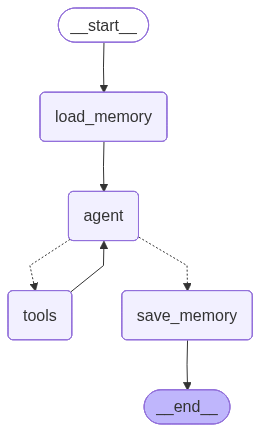


✅ Graph visualization displayed above


In [20]:
# Try to visualize the graph
try:
    from IPython.display import Image, display
    
    # Generate graph visualization
    graph_image = agent_graph.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("\n✅ Graph visualization displayed above")
except Exception as e:
    print(f"⚠️  Could not display graph visualization: {e}")
    print("\nGraph structure (text):")
    print("""    
    ┌─────────────┐
    │   START     │
    └──────┬──────┘
           │
           ▼
    ┌─────────────┐
    │ load_memory │
    └──────┬──────┘
           │
           ▼
    ┌─────────────┐
    │    agent    │ ◄─────┐
    └──────┬──────┘       │
           │              │
      ┌────┴────┐         │
      │         │         │
      ▼         ▼         │
   [tools]  [respond]     │
      │                   │
      └───────────────────┘
                │
                ▼
         ┌─────────────┐
         │ save_memory │
         └──────┬──────┘
                │
                ▼
         ┌─────────────┐
         │     END     │
         └─────────────┘
    """)

---

## 🎬 Part 4: Demo the Agent

Now let's see our agent in action! We'll have a conversation with the agent and watch it:
- Search for courses
- Store memories about preferences
- Recall information from previous interactions

### Helper Function: Run Agent


In [21]:
async def run_agent(user_message: str, verbose: bool = True) -> str:
    """
    Run the agent with a user message.
    
    Args:
        user_message: The user's input
        verbose: Whether to print detailed execution info
    
    Returns:
        The agent's response
    """
    if verbose:
        print("=" * 80)
        print(f"👤 USER: {user_message}")
        print("=" * 80)
    
    # Create initial state
    initial_state = AgentState(
        messages=[HumanMessage(content=user_message)],
        student_id=STUDENT_ID,
        session_id=SESSION_ID,
        context={}
    )
    
    # Run the graph
    if verbose:
        print("\n🤖 AGENT EXECUTION:")
    
    final_state = await agent_graph.ainvoke(initial_state)

    # Extract the final response
    final_message = final_state["messages"][-1]
    response = final_message.content if hasattr(final_message, 'content') else str(final_message)
    
    if verbose:
        print("\n" + "=" * 80)
        print(f"🤖 ASSISTANT: {response}")
        print("=" * 80)
    
    return response

print("✅ Helper function defined: run_agent")

✅ Helper function defined: run_agent


### Demo 1: Search Courses

Let's ask the agent to find machine learning courses.


In [22]:
# Demo 1: Search for courses
response1 = await run_agent(
    "What machine learning courses are available? I'm interested in intermediate level courses."
)

👤 USER: What machine learning courses are available? I'm interested in intermediate level courses.

🤖 AGENT EXECUTION:
19:57:54 httpx INFO   HTTP Request: GET http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&namespace=redis_university&model_name=gpt-4o "HTTP/1.1 404 Not Found"


19:57:54 httpx INFO   HTTP Request: PUT http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&model_name=gpt-4o "HTTP/1.1 200 OK"


   No previous conversation found (new session)


19:57:54 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:57:55 httpx INFO   HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


19:57:58 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:57:58 httpx INFO   HTTP Request: GET http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&namespace=redis_university&model_name=gpt-4o "HTTP/1.1 200 OK"


19:57:58 httpx INFO   HTTP Request: PUT http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&model_name=gpt-4o "HTTP/1.1 200 OK"


   Saved 2 messages to working memory

🤖 ASSISTANT: Here are some intermediate-level courses related to machine learning that you might find interesting:

1. **MATH022: Linear Algebra**
   - **Credits:** 3
   - **Format:** In-person
   - **Description:** Covers vector spaces, matrices, eigenvalues, and linear transformations. This course is essential for data science and engineering, providing foundational knowledge for machine learning.

2. **MATH023: Linear Algebra**
   - **Credits:** 3
   - **Format:** Hybrid
   - **Description:** Similar to MATH022, this course also covers vector spaces, matrices, eigenvalues, and linear transformations, with a hybrid format for more flexibility.

These courses focus on linear algebra, which is a crucial component of machine learning. If you're looking for more specific machine learning algorithms and applications, you might consider advanced courses like CS007: Machine Learning, which covers supervised and unsupervised learning, neural networks, a

### Demo 2: Store Preferences

Now let's share some preferences and watch the agent store them.


In [23]:
# Demo 2: Store preferences
response2 = await run_agent(
    "I prefer online courses because I have a part-time job. "
    "Also, I'm really interested in AI and want to work at a startup after graduation."
)

👤 USER: I prefer online courses because I have a part-time job. Also, I'm really interested in AI and want to work at a startup after graduation.

🤖 AGENT EXECUTION:
19:57:58 httpx INFO   HTTP Request: GET http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&namespace=redis_university&model_name=gpt-4o "HTTP/1.1 200 OK"


   Loaded 2 messages from working memory


19:57:59 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:57:59 httpx INFO   HTTP Request: POST http://localhost:8088/v1/long-term-memory/ "HTTP/1.1 200 OK"


19:57:59 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:57:59 httpx INFO   HTTP Request: POST http://localhost:8088/v1/long-term-memory/ "HTTP/1.1 200 OK"


19:58:01 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:58:02 httpx INFO   HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


19:58:04 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:58:04 httpx INFO   HTTP Request: GET http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&namespace=redis_university&model_name=gpt-4o "HTTP/1.1 200 OK"


19:58:04 httpx INFO   HTTP Request: PUT http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&model_name=gpt-4o "HTTP/1.1 200 OK"


   Saved 4 messages to working memory

🤖 ASSISTANT: Here are some intermediate-level machine learning-related courses that might interest you, especially considering your preference for online formats:

1. **CS007: Machine Learning**
   - **Credits:** 4
   - **Format:** Hybrid
   - **Level:** Advanced
   - **Description:** This course introduces machine learning algorithms and applications, covering supervised and unsupervised learning, neural networks, and more. It's a great fit if you're looking to deepen your understanding of machine learning.

2. **MATH023: Linear Algebra**
   - **Credits:** 3
   - **Format:** Hybrid
   - **Level:** Intermediate
   - **Description:** This course covers vector spaces, matrices, eigenvalues, and linear transformations, which are essential for data science and engineering. The hybrid format offers some flexibility.

While CS007 is more advanced, it aligns well with your interest in AI. If you're looking for more online options, let me know, and I can 

### Demo 3: Recall Memories

Let's ask the agent to recall what it knows about us.


In [24]:
# Demo 3: Recall memories
response3 = await run_agent(
    "What do you remember about my preferences and goals?"
)

👤 USER: What do you remember about my preferences and goals?

🤖 AGENT EXECUTION:
19:58:04 httpx INFO   HTTP Request: GET http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&namespace=redis_university&model_name=gpt-4o "HTTP/1.1 200 OK"


   Loaded 4 messages from working memory


19:58:05 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:58:05 httpx INFO   HTTP Request: POST http://localhost:8088/v1/long-term-memory/ "HTTP/1.1 200 OK"


19:58:06 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:58:06 httpx INFO   HTTP Request: GET http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&namespace=redis_university&model_name=gpt-4o "HTTP/1.1 200 OK"


19:58:06 httpx INFO   HTTP Request: PUT http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&model_name=gpt-4o "HTTP/1.1 200 OK"


   Saved 6 messages to working memory

🤖 ASSISTANT: I've noted your preference for online courses due to your part-time job and your interest in AI with a goal to work at a startup after graduation. If you need more information or have other preferences, feel free to let me know!


### Demo 4: Personalized Recommendations

Now let's ask for recommendations and see if the agent uses our stored preferences.


In [25]:
# Demo 4: Personalized recommendations
response4 = await run_agent(
    "Can you recommend some courses for next semester based on what you know about me?"
)

👤 USER: Can you recommend some courses for next semester based on what you know about me?

🤖 AGENT EXECUTION:
19:58:06 httpx INFO   HTTP Request: GET http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&namespace=redis_university&model_name=gpt-4o "HTTP/1.1 200 OK"


   Loaded 6 messages from working memory


19:58:07 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:58:07 httpx INFO   HTTP Request: POST http://localhost:8088/v1/long-term-memory/ "HTTP/1.1 200 OK"


19:58:09 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:58:09 httpx INFO   HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


19:58:10 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19:58:11 httpx INFO   HTTP Request: GET http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&namespace=redis_university&model_name=gpt-4o "HTTP/1.1 200 OK"


19:58:11 httpx INFO   HTTP Request: PUT http://localhost:8088/v1/working-memory/session_student_sarah_001_20251031_195753?user_id=student_sarah_001&model_name=gpt-4o "HTTP/1.1 200 OK"


   Saved 8 messages to working memory

🤖 ASSISTANT: Here are some intermediate-level machine learning-related courses that might interest you, especially considering your preference for online formats:

1. **CS007: Machine Learning**
   - **Credits:** 4
   - **Format:** Hybrid
   - **Level:** Advanced
   - **Description:** This course introduces machine learning algorithms and applications, covering supervised and unsupervised learning, neural networks, and more. It's a great fit if you're looking to deepen your understanding of machine learning.

2. **MATH023: Linear Algebra**
   - **Credits:** 3
   - **Format:** Hybrid
   - **Level:** Intermediate
   - **Description:** This course covers vector spaces, matrices, eigenvalues, and linear transformations, which are essential for data science and engineering. The hybrid format offers some flexibility.

While CS007 is more advanced, it aligns well with your interest in AI. If you're looking for more online options, let me know, and I can 

### Inspect Stored Memories

Let's look at what's actually stored in long-term memory.


In [26]:
# Check what's in long-term memory
try:
    from agent_memory_client.filters import UserId
    
    results = await memory_client.search_long_term_memory(
        text="preferences goals interests",
        user_id=UserId(eq=STUDENT_ID),
        limit=10
    )
    
    print("=" * 80)
    print("💾 LONG-TERM MEMORY CONTENTS")
    print("=" * 80)
    
    if results.memories and len(results.memories) > 0:
        for i, memory in enumerate(results.memories, 1):
            print(f"\n{i}. [{memory.memory_type}] {memory.text}")
            if memory.topics:
                print(f"   Topics: {', '.join(memory.topics)}")
            if memory.created_at:
                print(f"   Created: {memory.created_at}")
    else:
        print("\nNo memories found.")
    
    print("\n" + "=" * 80)
except Exception as e:
    print(f"Error retrieving memories: {e}")

19:58:11 httpx INFO   HTTP Request: POST http://localhost:8088/v1/long-term-memory/search?optimize_query=false "HTTP/1.1 200 OK"


💾 LONG-TERM MEMORY CONTENTS

1. [MemoryTypeEnum.SEMANTIC] User prefers online courses because of their part-time job and is interested in AI, aiming to work at a startup after graduation.
   Topics: preferences, goals, career goals
   Created: 2025-10-31 23:34:56.348080+00:00

2. [MemoryTypeEnum.SEMANTIC] User is interested in intermediate level machine learning courses
   Topics: education, machine learning
   Created: 2025-10-31 23:57:59.851662+00:00

3. [MemoryTypeEnum.SEMANTIC] User is interested in intermediate-level machine learning courses.
   Topics: education, machine learning
   Created: 2025-10-31 23:41:07.649462+00:00

4. [MemoryTypeEnum.SEMANTIC] User is interested in intermediate level machine learning courses.
   Topics: education, machine learning
   Created: 2025-10-31 23:38:59.455948+00:00

5. [MemoryTypeEnum.SEMANTIC] User is interested in AI and wants to work at a startup after graduation.
   Topics: career goals, interests
   Created: 2025-10-31 23:34:51.334794+00:

---

## 📊 Part 5: RAG vs Agent Comparison

Let's compare what we've built across the sections:

### **Section 2: Basic RAG**
```python
# Simple flow
query → search_courses() → generate_response()
```
- ✅ Can retrieve course information
- ❌ No memory of previous interactions
- ❌ Can't store user preferences
- ❌ Single-step only

### **Section 3: Memory-Enhanced RAG**
```python
# With memory
load_memory() → search_courses() → generate_response() → save_memory()
```
- ✅ Remembers conversation history
- ✅ Can reference previous messages
- ⚠️  Limited to predefined flow
- ❌ Can't decide when to store memories

### **Section 4: Full Agent (This Notebook)**
```python
# Agent with tools and decision-making
load_memory() → agent_decides() → [search_courses | search_memories | store_memory]* → save_memory()
```
- ✅ Remembers conversation history
- ✅ Decides when to search courses
- ✅ Decides when to store memories
- ✅ Decides when to recall memories
- ✅ Can chain multiple operations
- ✅ Adaptive to user needs

### **Key Differences:**

| Feature | RAG | Memory-RAG | Agent |
|---------|-----|------------|-------|
| **Retrieval** | ✅ | ✅ | ✅ |
| **Conversation Memory** | ❌ | ✅ | ✅ |
| **Long-term Memory** | ❌ | ⚠️ (manual) | ✅ (automatic) |
| **Decision Making** | ❌ | ❌ | ✅ |
| **Multi-step Reasoning** | ❌ | ❌ | ✅ |
| **Tool Selection** | ❌ | ❌ | ✅ |
| **Complexity** | Low | Medium | High |
| **Latency** | Low | Medium | Higher |
| **Cost** | Low | Medium | Higher |

**💡 Key Insight:** Agents add decision-making and multi-step reasoning to RAG systems.


---

## 🏗️ Architecture Recap

### **What We Built:**

A complete course advisor agent with:

**1. Tools (3 total)**
- `search_courses` - Semantic search over course catalog
- `search_memories` - Recall user preferences and facts
- `store_memory` - Save important information

**2. Memory Architecture**
- **Working Memory** - Conversation history (session-scoped)
- **Long-term Memory** - User preferences and facts (persistent)
- **Graph State** - Current execution state (turn-scoped)

**3. LangGraph Workflow**
- **Nodes**: load_memory, agent, tools, save_memory
- **Edges**: Conditional routing based on LLM decisions
- **State**: Shared data structure flowing through the graph

**4. Integration Points**
- **Redis** - Course catalog storage and vector search
- **Agent Memory Server** - Working and long-term memory
- **OpenAI** - LLM for reasoning and tool selection
- **LangGraph** - Workflow orchestration

### **The Complete Context Engineering Stack:**

```
┌─────────────────────────────────────────────────────────┐
│                    AGENT LAYER                          │
│  (LangGraph orchestration + tool selection)             │
└────────────────────┬────────────────────────────────────┘
                     │
        ┌────────────┼────────────┐
        │            │            │
        ▼            ▼            ▼
   ┌────────┐  ┌─────────┐  ┌─────────┐
   │ Tools  │  │ Memory  │  │   RAG   │
   └────────┘  └─────────┘  └─────────┘
        │            │            │
        └────────────┼────────────┘
                     │
                     ▼
            ┌─────────────────┐
            │  Redis Stack    │
            │  (Storage +     │
            │   Vector Search)│
            └─────────────────┘
```


---

## 🎓 Key Takeaways

### **1. Agents = RAG + Tools + Decision-Making**
- RAG retrieves information
- Tools enable actions
- Agents decide when to use each

### **2. Memory is Critical for Personalization**
- Working memory enables conversation continuity
- Long-term memory enables personalization
- Agents can decide when to store/recall memories

### **3. LangGraph Simplifies Complex Workflows**
- State management is automatic
- Conditional routing is declarative
- Visualization helps debugging

### **4. Tool Design Matters**
- Clear descriptions guide LLM selection
- Well-defined schemas prevent errors
- Focused tools are better than Swiss Army knives

### **5. Trade-offs to Consider**
- **Complexity**: Agents are more complex than RAG
- **Latency**: Multiple tool calls add latency
- **Cost**: More LLM calls = higher cost
- **Value**: Worth it for complex, multi-step tasks

### **6. When to Use Agents vs RAG**

**Use RAG when:**
- Simple question answering
- Single-step retrieval
- Low latency required
- Predictable workflows

**Use Agents when:**
- Multi-step reasoning needed
- Actions beyond retrieval
- Personalization required
- Complex decision-making


---

## 🚀 Next Steps and Extensions

### **Ideas to Extend This Agent:**

1. **Add More Tools**
   - `check_prerequisites` - Verify if student meets course requirements
   - `get_course_details` - Get detailed info about a specific course
   - `create_schedule` - Build a semester schedule
   - `check_conflicts` - Detect time conflicts

2. **Enhance Memory**
   - Automatic memory extraction from conversations
   - Memory summarization for long conversations
   - Memory importance scoring
   - Memory expiration policies

3. **Improve Personalization**
   - Learning style detection
   - Career path recommendations
   - Skill gap analysis
   - Progress tracking

4. **Add Guardrails**
   - Input validation
   - Output filtering
   - Rate limiting
   - Error handling

5. **Production Considerations**
   - Authentication and authorization
   - Logging and monitoring
   - Caching for performance
   - Fallback strategies

### **Reference Implementation:**

Check out `reference-agent/` for a full production implementation with:
- 7 tools (vs our 3)
- Advanced memory management
- Semantic tool selection
- Comprehensive error handling
- CLI interface
- Full test suite


---

## 🎉 Congratulations!

You've completed the Context Engineering course! You've learned:

**Section 1:** Context Types
- System, User, Conversation, Retrieved context
- How context shapes LLM behavior

**Section 2:** RAG Foundations
- Semantic search with vector embeddings
- Context assembly and generation
- Building a course search system

**Section 3:** Memory Architecture
- Working memory for conversation continuity
- Long-term memory for persistent knowledge
- Memory-enhanced RAG systems

**🔬 Research Foundation:** Throughout this course, you've learned techniques validated by Context Rot research - prioritizing relevance over quantity, filtering distractors, and structuring context for optimal LLM performance. ([Context Rot paper](https://research.trychroma.com/context-rot))

**Section 4:** Agents and Tools
- Tool calling fundamentals
- LangGraph workflow orchestration
- Building a complete course advisor agent
- Agents vs RAG trade-offs

### **You Can Now:**
- ✅ Design effective context strategies
- ✅ Build RAG systems with Redis
- ✅ Implement dual-memory architectures
- ✅ Create agents with tools and decision-making
- ✅ Choose the right approach for your use case

### **Keep Learning:**
- Explore the reference-agent implementation
- Experiment with different tools
- Try different LLMs and embeddings
- Build your own agents!

---

## 📚 Additional Resources


- [Agent Memory Server Documentation](https://github.com/redis/agent-memory-server) - Production-ready memory management
- [Agent Memory Client](https://pypi.org/project/agent-memory-client/) - Python client for Agent Memory Server
- [RedisVL Documentation](https://redisvl.com/) - Redis Vector Library
- [Retrieval-Augmented Generation Paper](https://arxiv.org/abs/2005.11401) - Original RAG research
- [LangChain RAG Tutorial](https://python.langchain.com/docs/use_cases/question_answering/) - Building RAG systems
- [LangGraph Tutorials](https://langchain-ai.github.io/langgraph/tutorials/) - Building agents with LangGraph
- [Agent Architectures](https://python.langchain.com/docs/modules/agents/) - Different agent patterns
- [ReAct: Synergizing Reasoning and Acting](https://arxiv.org/abs/2210.03629) - Reasoning + acting in LLMs
- [Anthropic's Guide to Building Effective Agents](https://www.anthropic.com/research/building-effective-agents) - Agent design patterns

---

**Thank you for completing this course! 🙏**
